### Text Classification - BBC Dataset

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

import mlflow
import mlflow.sklearn

In [2]:
data = pd.read_csv('./Assignment2_BBCNewsData.csv')

### Exploratory Data Analysis

In [3]:
data

,No,News,Category
0,1,Ad sales boost Time Warner profit Quarterly p...,business
1,2,Dollar gains on Greenspan speech The dollar h...,business
2,3,Yukos unit buyer faces loan claim The owners ...,business
3,4,High fuel prices hit BA's profits British Air...,business
4,5,Pernod takeover talk lifts Domecq Shares in U...,business
...,...,...,...
2220,2221,BT program to beat dialler scams BT is introd...,tech
2221,2222,Spam e-mails tempt net shoppers Computer user...,tech
2222,2223,Be careful how you code A new European direct...,tech
2223,2224,US cyber security chief resigns The man makin...,tech


In [4]:
data.describe()

,No
count,2225.000000
mean,1113.000000
std,642.446496
min,1.000000
25%,557.000000
50%,1113.000000
75%,1669.000000
max,2225.000000


https://towardsdatascience.com/text-classification-in-python-dd95d264c802

In [5]:
balance = data.groupby(['Category']).count()
balance['No'] = list(map(lambda x: (x/2225)*100, balance['No']))
balance.columns = ['Percent of Articles','Count']
balance

,Percent of Articles,Count
Category,,
business,22.921348,510
entertainment,17.348315,386
politics,18.741573,417
sport,22.966292,511
tech,18.022472,401


##### Are the categories balanced?

A critical question for text analysis.

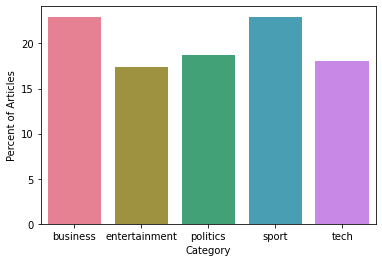

In [6]:
sns.barplot(x=balance.index, y='Percent of Articles', data=balance,palette='husl')
#Categories are reasonably balanced

In [7]:
data['Length'] = list(map(lambda x: 2225 if len(x)>7500 else len(x), data['News']))

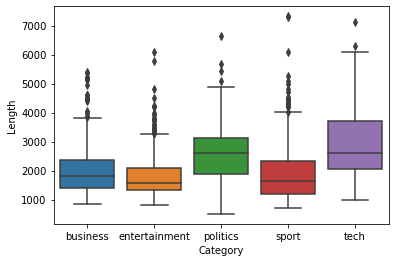

In [8]:
sns.boxplot(x='Category', y='Length', data=data)

### Feature Engineering

In [9]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer 


def textPreprocessor(x):
    #remove non-predictive punctuation
    x = re.sub("([^\w\s])", " ", x)
    #remove non-predictive case
    x = x.lower()
    x_tokens = word_tokenize(x)
    #remove non-predictive stopwords
    x_nosw = [word for word in x_tokens if not word in stopwords.words()]
    #lemmatize a.k.a reduce to atomic meaning, and then join and return
    return ' '.join([lemmatizer.lemmatize(w) for w in x_nosw])

def cleanText(column):
    lemmatizer = WordNetLemmatizer()
    #returns column of clean data
    return list(map(textPreprocessor,column))

<>:13: DeprecationWarning: invalid escape sequence \w
<>:13: DeprecationWarning: invalid escape sequence \w
<>:13: DeprecationWarning: invalid escape sequence \w
<ipython-input-9-89277a12bfd7>:13: DeprecationWarning: invalid escape sequence \w
  x = re.sub("([^\w\s])", " ", x)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ayon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ayon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
#This line is ridiculously slow, try to avoid running it
#THE CLEANED DATA IS ON A CSV WITHIN THE DIRECTORY
#newsList = list(data['News'])

In [11]:
#pd.DataFrame(cleanText(newsList)).to_csv('cleanedNews')

In [12]:
cleanNews = pd.read_csv('cleanedNews')

In [13]:
data['News'] = cleanNews['0']

In [14]:
data['Category'].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [15]:
def labelCoder(x):
    dict = {
        'business': 0,
        'entertainment':1,
        'politics':2,
        'sport':3,
        'tech':4,
        0:'business',
        1:'entertainment',
        2:'politics',
        3:'sport',
        4:'tech'
    }
    
    return dict[x]

In [16]:
data['Category'] = list(map(labelCoder,data['Category']))

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vectorizationPipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())])

In [18]:
x = data['News']
y = data['Category']

In [19]:
vectorizationPipeline.fit(x)
x = vectorizationPipeline.transform(x)

In [20]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("MultilabelNewsClassification")

INFO: 'MultilabelNewsClassification' does not exist. Creating a new experiment


In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def mlfRunner(x,y,model_name="RandomForestClassifier",model_choice=RandomForestClassifier(max_depth=10, random_state=0),t_size=0.2,r_state=365):
    
    with mlflow.start_run(run_name=model_name) as run:
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=t_size,random_state=r_state)
        # Create model, train it, and create predictions
        
        r = model_choice
        
        model = r.fit(X_train,y_train)
        p = model.predict(X_test)
        
        # Log params
        #mlflow.log_params({'max_depth':[2],'random_state':[1]})
  
        # Log model
        mlflow.sklearn.log_model(model, model_name)
        
        # Create metrics, do weird lambda stuff to deal with string category labels
        accuracy = accuracy_score(y_test, p)

        a = round(accuracy_score(y_test, r.predict(X_test)),2)
        h = round(hamming_loss(y_test, r.predict(X_test)),2)
        p = round(precision_score(y_test, r.predict(X_test), average='macro'),2)
        
        print("Accuracy score: " + str(a) + " %")
        print("Hamming loss: " + str(h) + " %")
        print("Precision score: " + str(p) + " %")
        
        # Log metrics
        mlflow.log_metrics({"accuracy": a, "hamming":h,"precision":p})
            
        runID = run.info.run_uuid
        experimentID = run.info.experiment_id
  
        print(f"Inside MLflow Run with run_id `{runID}` and experiment_id `{experimentID}`")
        mlflow.end_run()

In [34]:
mlfRunner(x,y)

Accuracy score: 0.96 %
Hamming loss: 0.04 %
Inside MLflow Run with run_id `429838e559d94c7a8655192d60eae849` and experiment_id `1`


In [39]:
from sklearn.svm import LinearSVC

mlfRunner(x,y,'LinearSVC',LinearSVC(multi_class='crammer_singer',random_state=0))

Accuracy score: 0.98 %
Hamming loss: 0.02 %
Inside MLflow Run with run_id `4ab6adb90c404c699cd2de62dde80d98` and experiment_id `1`


In [40]:
from sklearn.neighbors import KNeighborsClassifier

mlfRunner(x,y,'KNN-2',KNeighborsClassifier(n_neighbors=2))
mlfRunner(x,y,'KNN-3',KNeighborsClassifier(n_neighbors=3))
mlfRunner(x,y,'KNN-4',KNeighborsClassifier(n_neighbors=4))

Accuracy score: 0.93 %
Hamming loss: 0.07 %
Inside MLflow Run with run_id `6639d4a91cdf4009a68cad773d34c227` and experiment_id `1`
Accuracy score: 0.93 %
Hamming loss: 0.07 %
Inside MLflow Run with run_id `d899e922da2948b2bdbb98b377058b76` and experiment_id `1`
Accuracy score: 0.94 %
Hamming loss: 0.06 %
Inside MLflow Run with run_id `b7be0f56b3904772ad513bfe78456a7b` and experiment_id `1`


In [41]:
from sklearn.naive_bayes import BernoulliNB

mlfRunner(x,y,'Bernoulli-Naive-Bayes',BernoulliNB())

Accuracy score: 0.96 %
Hamming loss: 0.04 %
Inside MLflow Run with run_id `3fdf64907ea14c00a3dfc362663e25aa` and experiment_id `1`


In [43]:
from sklearn.linear_model import LogisticRegression

mlfRunner(x,y,'LogisticRegression-Multinomial',LogisticRegression(multi_class='multinomial', random_state=0))

Accuracy score: 0.98 %
Hamming loss: 0.02 %
Inside MLflow Run with run_id `d916d36089e944c3a645c61dffc19980` and experiment_id `1`


In [ ]:
techSample = ['Hungarian autonomous driving startup AImotive is leveraging its technology to address a different industry and growing need: autonomous satellite operation. AImotive is teaming up with C3S, a supplier of satellite and space-based technologies, to develop a hardware platform for performing AI operations onboard satellites. AImotive’s aiWare neural network accelerator will be optimized by C3S for use on satellites, which have a set of operating conditions that in many ways resembles those onboard cars on the road – but with more stringent requirements in terms of power management, and environmental operating hazards.']

techSample = vectorizationPipeline.transform(techSample)

labelCoder(clf.predict(techSample)[0])

In [ ]:
techSample = ['Hungarian autonomous driving startup AImotive is leveraging its technology to address a different industry and growing need: autonomous satellite operation. AImotive is teaming up with C3S, a supplier of satellite and space-based technologies, to develop a hardware platform for performing AI operations onboard satellites. AImotive’s aiWare neural network accelerator will be optimized by C3S for use on satellites, which have a set of operating conditions that in many ways resembles those onboard cars on the road – but with more stringent requirements in terms of power management, and environmental operating hazards.']
techSample = vectorizationPipeline.transform(techSample)

bizSample = ['Governments around the world are spending like never before to kick-start their economies in the wake of Covid-19 lockdowns, in many cases tying green initiatives to rescue packages, even as some industries say saving jobs should trump environmental concerns. ']
bizSample = vectorizationPipeline.transform(bizSample)

labelCoder(clf.predict(bizSample)[0])